# SITCOM-797

Here is what was requested:

To analyze the positioning system after a slew, create plots for the mirror

- decentering (X and Y)
- mirror tilt (RX, RY, RY)
- piston
- Create a histogram for each parameter for a configurable time period.

Include the limits in all plots:

* the mirror decenters at less than +/- 6 micrometer
* mirror tilt less than +/- 24 e-6 degree
* piston less than +/- 1 micrometer


### Prepare Notebook

In [15]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from astropy import time
import matplotlib.dates as mdates

from lsst.summit.utils.tmaUtils import TMAEventMaker, TMAState
from lsst.summit.utils.efdUtils import getEfdData, makeEfdClient

In [3]:
# Select data from a given date
dayObs = 20230601
eventMaker = TMAEventMaker()
events = eventMaker.getEvents(dayObs)

# Get lists of slew and track events
slews = [e for e in events if e.type==TMAState.SLEWING]
tracks = [e for e in events if e.type==TMAState.TRACKING]
print(f'Found {len(slews)} slews and {len(tracks)} tracks')

Found 117 slews and 0 tracks


In [4]:
# create a client to retrieve datasets in the EFD database
client = makeEfdClient()

In [5]:
# select one particular slew event
i_slew = 3

all_columns = ["xPosition", "xRotation", "yPosition", "yRotation", "zPosition", "zRotation"]
pos_columns = [c for c in all_columns if "Position" in c]
rot_columns = [c for c in all_columns if "Rotation" in c]

In [10]:
# Get ims data
df_ims = getEfdData(client, 'lsst.sal.MTM1M3.imsData', event=slews[i_slew])
df_ims = df_ims[all_columns]

# Convert meter to milimeter to make is easier to analyse
df_ims[pos_columns] = df_ims[pos_columns] * 1e3

In [11]:
# Get Hard Point states
# We should be careful here as getEfdData may return nothing if we pass the event as an argument. We should pass dayObs instead and check the HP state explicitly
# for the time frame corresponding to the event
df_HPState = getEfdData(client, 'lsst.sal.MTM1M3.logevent_hardpointActuatorState', dayObs = dayObs)

In [6]:
slews[8]

dayObs: 20230601
seqNum: 8
type: SLEWING
endReason: STOPPED
duration: 101.46082782745361
begin: <Time object: scale='tai' format='unix_tai' value=1685667549.0464532>,
end: <Time object: scale='tai' format='unix_tai' value=1685667650.507281>
beginFloat: 1685667549.0464532
endFloat: 1685667650.507281


In [108]:
slews[i_slew].duration

26.065403938293457

In [13]:
#Convert begin and end event time to something compatible with pandas
t0 = pd.to_datetime(slews[i_slew].beginFloat, unit="s", utc=True)
t1 = pd.to_datetime(slews[i_slew].endFloat, unit="s", utc=True)

In [14]:
# Find the closest HP state preceding the event begin time 
res = df_HPState.index.get_indexer([t0], method='pad')
t = df_HPState.index[res[0]]

# IF HP is stable then the six motionState values should be equal to 0
#df_HPState[t:t]
HP_global_state = (df_HPState[t:t][[f"motionState{j}" for j in range(6)]] == 0).all(axis=1)
if not HP_global_state.values[0]:
    print("HP is not in a stable state\n", (df_HPState[t:t][[f"motionState{j}" for j in range(6)]] == 0))

In [15]:
# Get elevation and azimuth data
df_ele = getEfdData(client, 'lsst.sal.MTMount.elevation', event= slews[i_slew])
df_azi = getEfdData(client, 'lsst.sal.MTMount.azimuth', event= slews[i_slew])

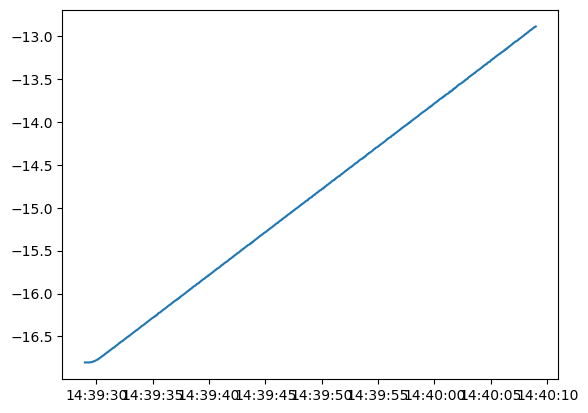

In [16]:
plt.plot(df_azi.index, df_azi['actualPosition'])

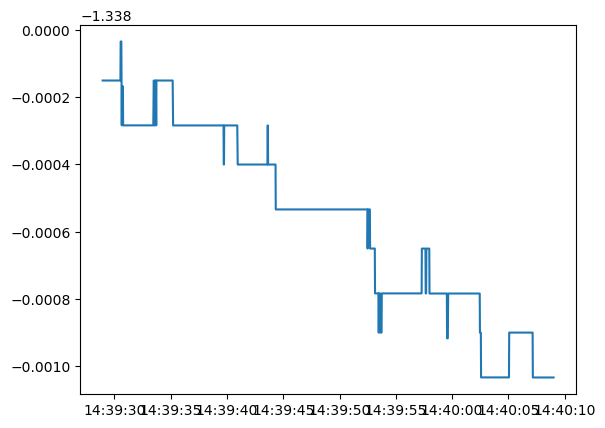

In [17]:
plt.plot(df_ims.index, df_ims["zPosition"])

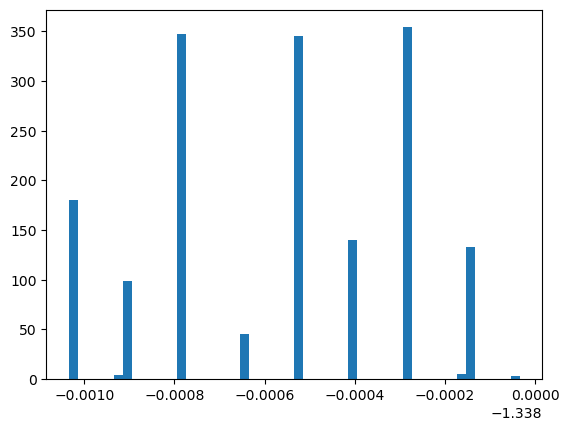

In [18]:
_ = plt.hist(df_ims["zPosition"], bins=50)

In [19]:
df_ele

,actualPosition,actualTorque,actualVelocity,demandPosition,demandVelocity,private_efdStamp,private_identity,private_kafkaStamp,private_origin,private_rcvStamp,private_revCode,private_seqNum,private_sndStamp,timestamp
2023-05-31 14:39:28.995524+00:00,89.959044,0,-0.000230,89.977487,0,1.685544e+09,MTMount,1.685544e+09,43965,1.685544e+09,faa4549a,1106075,1.685544e+09,1.685544e+09
2023-05-31 14:39:29.031703+00:00,89.959044,0,0.000106,89.977487,0,1.685544e+09,MTMount,1.685544e+09,43965,1.685544e+09,faa4549a,1106076,1.685544e+09,1.685544e+09
2023-05-31 14:39:29.127068+00:00,89.959043,0,0.000124,89.977487,0,1.685544e+09,MTMount,1.685544e+09,43965,1.685544e+09,faa4549a,1106077,1.685544e+09,1.685544e+09
2023-05-31 14:39:29.171917+00:00,89.959044,0,-0.000468,89.977487,0,1.685544e+09,MTMount,1.685544e+09,43965,1.685544e+09,faa4549a,1106078,1.685544e+09,1.685544e+09
2023-05-31 14:39:29.283134+00:00,89.959044,0,-0.000005,89.977487,0,1.685544e+09,MTMount,1.685544e+09,43965,1.685544e+09,faa4549a,1106079,1.685544e+09,1.685544e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-31 14:40:08.691049+00:00,89.959038,0,0.000146,89.977487,0,1.685544e+09,MTMount,1.685544e+09,43965,1.685544e+09,faa4549a,1106616,1.685544e+09,1.685544e+09
2023-05-31 14:40:08.776855+00:00,89.959037,0,-0.000608,89.977487,0,1.685544e+09,MTMount,1.685544e+09,43965,1.685544e+09,faa4549a,1106617,1.685544e+09,1.685544e+09
2023-05-31 14:40:08.833860+00:00,89.959037,0,0.000079,89.977487,0,1.685544e+09,MTMount,1.685544e+09,43965,1.685544e+09,faa4549a,1106618,1.685544e+09,1.685544e+09
2023-05-31 14:40:08.927341+00:00,89.959037,0,0.000185,89.977487,0,1.685544e+09,MTMount,1.685544e+09,43965,1.685544e+09,faa4549a,1106619,1.685544e+09,1.685544e+09


In [20]:
df_azi

,actualPosition,actualTorque,actualVelocity,demandPosition,demandVelocity,private_efdStamp,private_identity,private_kafkaStamp,private_origin,private_rcvStamp,private_revCode,private_seqNum,private_sndStamp,timestamp
2023-05-31 14:39:28.994573+00:00,-16.803314,4791.114736,0.000057,-16.803315,0.000000,1.685544e+09,MTMount,1.685544e+09,43965,1.685544e+09,c5f1e359,1106316,1.685544e+09,1.685544e+09
2023-05-31 14:39:29.031196+00:00,-16.803315,4940.261597,0.000079,-16.803315,0.000000,1.685544e+09,MTMount,1.685544e+09,43965,1.685544e+09,c5f1e359,1106317,1.685544e+09,1.685544e+09
2023-05-31 14:39:29.125866+00:00,-16.803315,5019.668638,0.000246,-16.803315,0.000000,1.685544e+09,MTMount,1.685544e+09,43965,1.685544e+09,c5f1e359,1106318,1.685544e+09,1.685544e+09
2023-05-31 14:39:29.171268+00:00,-16.803315,5159.030971,-0.000049,-16.803309,0.000544,1.685544e+09,MTMount,1.685544e+09,43965,1.685544e+09,c5f1e359,1106319,1.685544e+09,1.685544e+09
2023-05-31 14:39:29.282651+00:00,-16.803266,14212.955201,0.001870,-16.802929,0.008300,1.685544e+09,MTMount,1.685544e+09,43965,1.685544e+09,c5f1e359,1106320,1.685544e+09,1.685544e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-31 14:40:08.690340+00:00,-12.912520,6763.560548,0.099979,-12.900015,0.100000,1.685544e+09,MTMount,1.685544e+09,43965,1.685544e+09,c5f1e359,1106857,1.685544e+09,1.685544e+09
2023-05-31 14:40:08.775601+00:00,-12.907519,6769.757349,0.100613,-12.895015,0.100000,1.685544e+09,MTMount,1.685544e+09,43965,1.685544e+09,c5f1e359,1106858,1.685544e+09,1.685544e+09
2023-05-31 14:40:08.833360+00:00,-12.897517,6377.324566,0.099762,-12.885015,0.100000,1.685544e+09,MTMount,1.685544e+09,43965,1.685544e+09,c5f1e359,1106859,1.685544e+09,1.685544e+09
2023-05-31 14:40:08.926129+00:00,-12.892516,6351.727383,0.100639,-12.880015,0.100000,1.685544e+09,MTMount,1.685544e+09,43965,1.685544e+09,c5f1e359,1106860,1.685544e+09,1.685544e+09


## Analysis

 * Loop over all the slews
 * Compute mean, sigma and maximum difference w.r.t. the first values
 * Store results in a dataframe in order to plot them later

In [36]:
# define small amount of time to check mirror position before and after the slews
delta_t = 1
dt_begin = time.TimeDelta(-delta_t, format='sec')
dt_end = time.TimeDelta(delta_t, format='sec')

results = pd.DataFrame(columns=["i_slew", "duration", "x_mean", "y_mean", "z_mean", "x_sigma", "y_sigma", "z_sigma", 
                                "R_x_mean", "R_y_mean", "R_z_mean", "Rx_sigma", "Ry_sigma", "Rz_sigma",
                                "dx_max", "dy_max", "dz_max", "R_dx_max", "R_dy_max", "R_dz_max",
                                "x_before", "y_before", "z_before", "R_x_before", "R_y_before", "R_z_before",
                                "x_after", "y_after", "z_after", "R_x_after", "R_y_after", "R_z_after"])


for i_slew, slew in enumerate(slews):
    #print(i_slew)
    # Get ims data
    df_ims = getEfdData(client, 'lsst.sal.MTM1M3.imsData', event=slew)
    if len(df_ims) == 0:
        print(f"No data for slew number: {i_slew}")
        continue 
        
    df_ims = df_ims[all_columns]

    # Convert meter to milimeter to make is easier to analyse
    df_ims[pos_columns] = df_ims[pos_columns] * 1e3
    
    # get ims data before and after the slew
    df_ims_before = getEfdData(client, 'lsst.sal.MTM1M3.imsData', begin=slew.begin, timespan=dt_begin)
    df_ims_before = df_ims_before[all_columns]
    df_ims_before[pos_columns] = df_ims_before[pos_columns] * 1e3
    
    df_ims_after = getEfdData(client, 'lsst.sal.MTM1M3.imsData', begin=slew.end, timespan=dt_end)
    df_ims_after = df_ims_after[all_columns]
    df_ims_after[pos_columns] = df_ims_after[pos_columns] * 1e3
    
    mean = {}
    sigma = {}
    max_diff = {}
    mean_before={}
    mean_after = {}
    for col in all_columns:
        mean[col] = np.mean(df_ims[col])
        sigma[col] = np.std(df_ims[col])
        t0 = df_ims.index[0]
        max_diff[col] = np.max(np.abs(df_ims[t0:t0][col][0]-df_ims[col]))
        
        mean_before[col] = np.mean(df_ims_before[col])
        mean_after[col] = np.mean(df_ims_after[col])
        
    # Store computed values in dataframe
    vect = [[i_slew], [slew.duration], [mean[i] for i in pos_columns], [sigma[i] for i in pos_columns], [mean[i] for i in rot_columns], [sigma[i] for i in rot_columns],
            [max_diff[i] for i in pos_columns], [max_diff[i] for i in rot_columns],
            [mean_before[i] for i in pos_columns], [mean_before[i] for i in rot_columns], [mean_after[i] for i in pos_columns], [mean_after[i] for i in rot_columns]]
    flat_vect = [item for sublist in vect for item in sublist]
    results = pd.concat([results, pd.DataFrame([flat_vect], columns=results.columns)], ignore_index=True)
        

In [37]:
results

,i_slew,duration,x_mean,y_mean,z_mean,x_sigma,y_sigma,z_sigma,R_x_mean,R_y_mean,...,z_before,R_x_before,R_y_before,R_z_before,x_after,y_after,z_after,R_x_after,R_y_after,R_z_after
0,0,164.413610,-1.463755,5.575792,-1.315420,0.000411,0.001422,0.000348,-0.002654,-0.014211,...,-1.315375,-0.002669,-0.014215,0.008274,-1.463566,5.575097,-1.315931,-0.002652,-0.014207,0.008278
1,1,186.526611,-1.463415,5.575102,-1.316074,0.000224,0.000529,0.000104,-0.002651,-0.014208,...,-1.316092,-0.002654,-0.014212,0.008274,-1.463348,5.575741,-1.315848,-0.002646,-0.014210,0.008276
2,2,101.495021,-1.463309,5.573056,-1.316622,0.000100,0.000851,0.000463,-0.002657,-0.014212,...,-1.316036,-0.002652,-0.014216,0.008274,-1.463322,5.572547,-1.317371,-0.002656,-0.014207,0.008278
3,3,101.500050,-1.463297,5.574409,-1.316882,0.000112,0.000861,0.000589,-0.002652,-0.014207,...,-1.317700,-0.002659,-0.014213,0.008277,-1.463101,5.575307,-1.315597,-0.002645,-0.014206,0.008279
4,4,101.497192,-1.463099,5.572888,-1.316531,0.000067,0.000801,0.000503,-0.002656,-0.014214,...,-1.315870,-0.002649,-0.014215,0.008277,-1.463094,5.572572,-1.317383,-0.002655,-0.014211,0.008282
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,112,401.501974,-1.454083,5.544000,-1.316778,0.000852,0.001936,0.006588,-0.002545,-0.014256,...,-1.306471,-0.002541,-0.014249,0.008276,-1.452671,5.540931,-1.329673,-0.002554,-0.014264,0.008227
113,113,801.539738,-1.455198,5.549954,-1.307058,0.001344,0.005921,0.012441,-0.002514,-0.014256,...,-1.329041,-0.002548,-0.014260,0.008224,-1.457769,5.562435,-1.287053,-0.002463,-0.014279,0.008298
114,114,401.492525,-1.458054,5.556273,-1.296034,0.000279,0.002617,0.005715,-0.002518,-0.014264,...,-1.287096,-0.002460,-0.014284,0.008292,-1.458374,5.552900,-1.306435,-0.002565,-0.014253,0.008290
115,115,801.527980,-1.458803,5.562903,-1.290404,0.000686,0.005888,0.008167,-0.002475,-0.014272,...,-1.306398,-0.002561,-0.014256,0.008283,-1.460835,5.572176,-1.280114,-0.002446,-0.014290,0.008312


Text(0, 0.5, 'After - before positions in z (microns)')

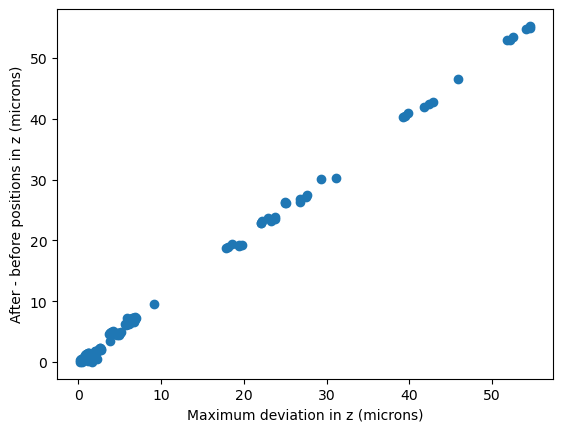

In [76]:
_ = plt.scatter(results["dz_max"]*1e3, abs(results["z_after"]-results["z_before"])*1e3)
plt.xlabel("Maximum deviation in z (microns)")
plt.ylabel("After - before positions in z (microns)")

Text(0, 0.5, 'After - before positions in z (microns)')

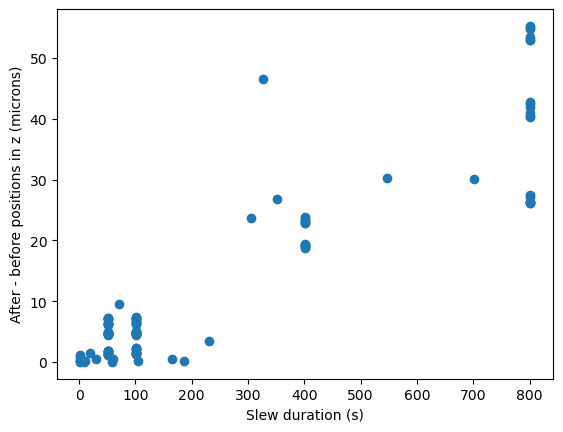

In [78]:
_ = plt.scatter(results["duration"], abs(results["z_after"]-results["z_before"])*1e3)
plt.xlabel("Slew duration (s)")
plt.ylabel("After - before positions in z (microns)")

(array([45., 34.,  3.,  1.,  2., 12.,  1.,  0.,  1., 18.]),
 array([7.38995552e-01, 8.08211971e+01, 1.60903399e+02, 2.40985600e+02,
        3.21067802e+02, 4.01150003e+02, 4.81232205e+02, 5.61314406e+02,
        6.41396608e+02, 7.21478810e+02, 8.01561011e+02]),
 <BarContainer object of 10 artists>)

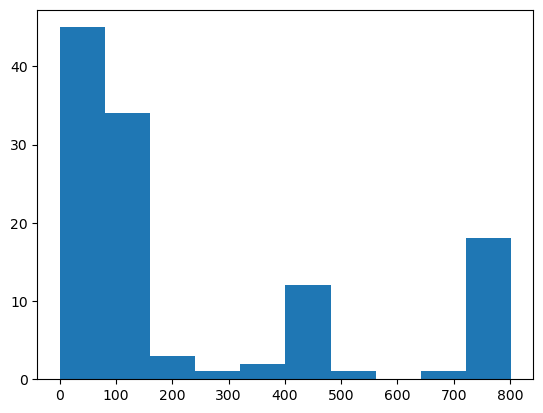

In [70]:
plt.hist(results["duration"])

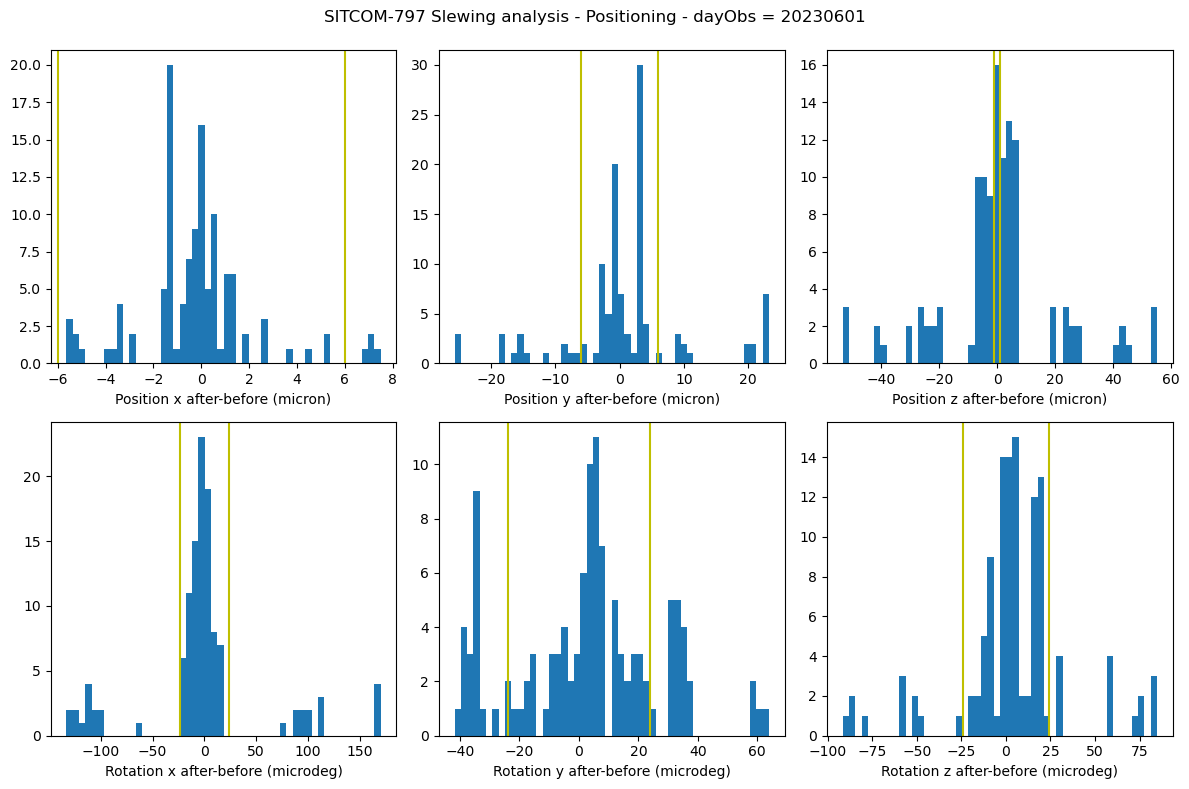

In [72]:
# Plot results for rotation analysis
locator = mdates.AutoDateLocator(minticks=3, maxticks=3)
formatter = mdates.ConciseDateFormatter(locator)

title = f"SITCOM-797 Slewing analysis - Positioning - dayObs = {dayObs}"
fig, axs = plt.subplots(num=title, nrows=2, ncols=3, figsize=(12, 8))

axes = [ "x", "y", "z"]
for i in range(3):
    diff = (results[f"{axes[i]}_after"] - results[f"{axes[i]}_before"])*1e3
    max = np.max(diff)
    min = np.min(diff)
    axs[0][i].hist(diff, bins=50) #range=[min-0.1*abs(min), max+0.1*abs(max)])
    axs[0][i].set_xlabel(f"Position {axes[i]} after-before (micron)")
    
    diff = (results[f"R_{axes[i]}_after"] - results[f"R_{axes[i]}_before"])*1e6
    max = np.max(diff)
    min = np.min(diff)
    axs[1][i].hist(diff, bins=50) #range=[min-0.1*abs(min), max+0.1*abs(max)])
    axs[1][i].set_xlabel(f"Rotation {axes[i]} after-before (microdeg)")
    
    if axes[i] in ["x", "y"]:
        axs[0][i].axvline(6, color='y')
        axs[0][i].axvline(-6, color='y')
        axs[1][i].axvline(24, color='y')
        axs[1][i].axvline(-24, color='y')
    else:
        axs[0][i].axvline(1, color='y')
        axs[0][i].axvline(-1, color='y')
        axs[1][i].axvline(24, color='y')
        axs[1][i].axvline(-24, color='y')
    
fig.suptitle(title + "\n")
fig.tight_layout()
plt.subplots_adjust(top=0.93)